<a href="https://colab.research.google.com/github/chungngoc/Text_Classification/blob/main/classification_questions_StackOverFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf.__version__)

2.8.0


Download and explore the Stack Overflow dataset

In [ ]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url, untar = True, cache_dir=".", cache_subdir='')

train_dir = os.path.join(os.path.dirname(dataset), 'train')

In [ ]:
os.listdir(train_dir)

['java', 'csharp', 'javascript', 'python']

In [ ]:
sample_file = os.path.join(train_dir, 'python/10.txt')

with open(sample_file) as f:
  print(f.read())

"how to read instance variables from another file without instantiating the class? i'm relatively new to blank and i'm having some trouble importing a variable to use it in another class. i did look at several other questions on this topic and tried to make it work, but it seems the way i set up this program early on might be the problem. i'll simplify what's going on so there's less to read.....server.py:..import game.class server():.    def __init__(self):.        # server connection details here.        self.test = 5.        self.game = game()..    def serve(self):.        # client processing, etc..        self.game.game_loop()..if __name__ == ""__main__"":.    server = server().    server.serve()...game.py:..class game():.    def __init__(self):.        # other variables.....    def game_loop(self):.        # to reference server's instance variables.        from server import server..        print test...in this example, i'm trying to reference the variable ""test"" from the server

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory('./train', batch_size=batch_size, 
                                                          validation_split=0.2, subset='training', 
                                                          seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [ ]:
# Create validation set
raw_val_ds = tf.keras.utils.text_dataset_from_directory('./train', batch_size=batch_size, 
                                                          validation_split=0.2, subset='validation', 
                                                          seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [ ]:
# Create test set
raw_test_ds = tf.keras.utils.text_dataset_from_directory('./test', batch_size=batch_size)

Found 8000 files belonging to 4 classes.


Prepare the dataset for training

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length)

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]

print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size  = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size  = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size  = AUTOTUNE)

Create Model

In [ ]:
embedding_dim = 16

model = tf.keras.Sequential([
                             layers.Embedding(max_features+1, embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(4)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

In [ ]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

Train the model

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs = 10)

Epoch 1/10
200/200 [==============================] - 4s 18ms/step - loss: 2.2325 - accuracy: 0.3184 - val_loss: 1.2471 - val_accuracy: 0.5437
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 1.1656 - accuracy: 0.5225 - val_loss: 1.0289 - val_accuracy: 0.5350
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.9661 - accuracy: 0.6359 - val_loss: 0.9964 - val_accuracy: 0.6294
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.9537 - accuracy: 0.6330 - val_loss: 1.1126 - val_accuracy: 0.5481
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.8997 - accuracy: 0.7097 - val_loss: 0.8642 - val_accuracy: 0.7694
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.7372 - accuracy: 0.7189 - val_loss: 0.8075 - val_accuracy: 0.7775
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.7739 - accuracy: 0.7167 - val_loss: 0.7789 - val_accuracy: 0.7713
Epoch

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 3s 10ms/step - loss: 1.1223 - accuracy: 0.5379
Loss:  1.1223061084747314
Accuracy:  0.5378749966621399


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

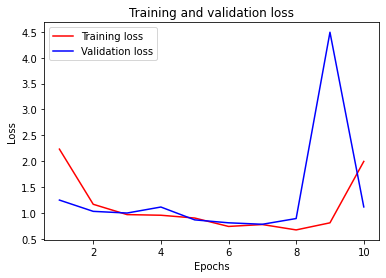

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)  + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

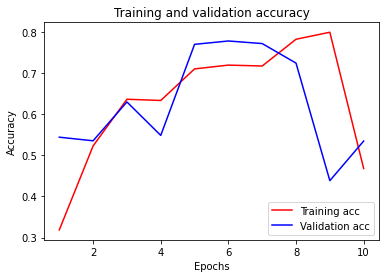

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
export_model = tf.keras.Sequential([
                                    vectorize_layer,
                                    model,
                                    layers.Activation('sigmoid')
])

export_model.compile(loss=losses.SparseCategoricalCrossentropy(),
                     optimizer = 'adam',
                     metrics = ['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 1.3617 - accuracy: 0.5379
0.5378749966621399


In [ ]:
examples = ["How to add an extra column to a NumPy array in Python ?",
            "Why is processing a sorted array faster than processing an unsorted array?",
            "The movie was terrible!!!",
            "This is the bad movie..."]

export_model.predict(examples)

array([[0.5210272 , 0.5249206 , 0.5173891 , 0.5091321 ],
       [0.52022403, 0.52475804, 0.51828164, 0.50817555],
       [0.5215579 , 0.5259594 , 0.5176362 , 0.5089606 ],
       [0.5215335 , 0.5258052 , 0.51728815, 0.5087294 ]], dtype=float32)